# Churn Analysis

In [1]:
import pandas as pd
import numpy as np

In [2]:
data = pd.read_feather('RC_2012_year_cohort.feather')
data.head()

,created_utc,author,subreddit
0,1325376000,irwinator,AskReddit
1,1325376000,reed311,politics
2,1325376000,sagapo3851,gaming
3,1325376000,filthgrinder,politics
4,1325376001,BitterDivorcedDad,WTF


### Find the top 30 subreddits


In [3]:
#count the number of comments by subreddit and take the first 30
top30 = data['subreddit'].value_counts().head(30)
top30 = pd.DataFrame(top30)
top30

,subreddit
AskReddit,32023468
funny,11909021
pics,8973606
gaming,6966306
WTF,6377885
politics,5397547
atheism,5043438
leagueoflegends,4029221
IAmA,3883036
trees,3846708


In [4]:
top30_list = list(top30.index)

In [5]:
top30_list

['AskReddit',
 'funny',
 'pics',
 'gaming',
 'WTF',
 'politics',
 'atheism',
 'leagueoflegends',
 'IAmA',
 'trees',
 'videos',
 'AdviceAnimals',
 'todayilearned',
 'fffffffuuuuuuuuuuuu',
 'worldnews',
 'gonewild',
 'nfl',
 'movies',
 'starcraft',
 'aww',
 'technology',
 'Minecraft',
 'soccer',
 'Music',
 'nba',
 'Diablo',
 'mylittlepony',
 'Guildwars2',
 'Games',
 'guns']

### Filter the dataframe so you are only looking at data form a single sub-reddit.


In [6]:
from datetime import datetime
def single_sub(name):
    #subsetting the dataframe from data
    df = data[data['subreddit'] == name][['created_utc', 'author']]
    #deleting deleted authors
    df = df[df['author'] != '[deleted]']
    #convert utc into timestamp
    df['created_utc'] = df['created_utc'].apply(datetime.fromtimestamp).dt.date
    return df

In [102]:
df1 = single_sub('Music').copy()

In [103]:
df1

,created_utc,author
282,2011-12-31,FightForYourMind
1618,2011-12-31,Dirtycuban55
1962,2011-12-31,ptfreak
2061,2011-12-31,McG4rn4gle
3496,2011-12-31,JedLeland
...,...,...
234225033,2012-11-30,clipper377
234225075,2012-11-30,planetdan
234225246,2012-11-30,Kirro24
234225305,2012-11-30,mojo996


In [10]:
dict_subreddit = {}
for i in top30_list:
    dict_subreddit[i] = single_sub(i)

In [11]:
dict_subreddit['Music']

,created_utc,author
282,2011-12-31,FightForYourMind
1618,2011-12-31,Dirtycuban55
1962,2011-12-31,ptfreak
2061,2011-12-31,McG4rn4gle
3496,2011-12-31,JedLeland
...,...,...
234225033,2012-11-30,clipper377
234225075,2012-11-30,planetdan
234225246,2012-11-30,Kirro24
234225305,2012-11-30,mojo996


### Find the date of first interaction (for that sub-reddit)


In [12]:
def first_interaction(df):
    #group by authors and select the first post day
    df_res = df.groupby('author').min().dropna()
    #rename the column day zero
    df_res = df_res.rename(columns={"created_utc": "day0"})
    return df_res

In [13]:
first_interaction(df1)

,day0
author,
-AlmightyGod-,2012-03-26
-Antrix-,2012-01-09
-DASH-,2012-09-29
-DannyBoy-,2012-01-06
-Dervish,2012-01-30
...,...
joemc33,2012-11-30
mastachieffz,2012-11-30
ratman0440,2012-11-30


In [14]:
dict_first = dict_subreddit.copy()
for key, value in dict_first.items():
    dict_first[key] = first_interaction(value)

In [15]:
dict_first['Music']

,day0
author,
-Axiom-,2012-07-03
-EdwardSharpe-,2012-05-20
-JS-,2012-01-02
-JuJu-,2012-01-03
-RdV-,2012-01-08
...,...
simple-minded,2012-11-30
star10159,2012-11-30
theotelos,2012-11-30


In [16]:
dict_subreddit['Music']

,created_utc,author
282,2011-12-31,FightForYourMind
1618,2011-12-31,Dirtycuban55
1962,2011-12-31,ptfreak
2061,2011-12-31,McG4rn4gle
3496,2011-12-31,JedLeland
...,...,...
234225033,2012-11-30,clipper377
234225075,2012-11-30,planetdan
234225246,2012-11-30,Kirro24
234225305,2012-11-30,mojo996


### Combine the initial dataframe with the dataframe containing comment timestamps


In [18]:
def f_merge(df1, df2):
    #merge the dataframe with first day of comment and the comment time on author
    df_res = df1.merge(df2, left_on='author', right_index=True)
    
    #calculate the time difference between comment time and first comment date
    df_res['day_since'] = df_res['created_utc'] - df_res['day0']
    
    #drop the original comment time column and day0 column
    df_res = df_res.drop(['created_utc', 'day0'], axis = 1)
    
    #drop the duplicate rows where the same author commented multiple times in a day
    df_res.drop_duplicates(keep = 'first', inplace = True)
    
    return df_res

In [19]:
df2 = f_merge(df1,first_interaction(df1))

In [20]:
df2

,author,day_since
11,99-LS1-SS,0 days
201794,99-LS1-SS,1 days
1291659,99-LS1-SS,3 days
1966648,99-LS1-SS,4 days
2488923,99-LS1-SS,5 days
...,...,...
234220436,hedorah3,0 days
234222345,daaays,0 days
234222955,DannyDarko84,0 days
234223773,stanleythecow,0 days


In [21]:
dict_days = dict_first.copy()
for key, value in dict_days.items():
    temp_dict = dict_subreddit[key]
    dict_days[key] = f_merge(temp_dict, value)

In [22]:
dict_days['Music']

,author,day_since
282,FightForYourMind,0 days
9085070,FightForYourMind,17 days
10348605,FightForYourMind,20 days
10486520,FightForYourMind,21 days
12361373,FightForYourMind,24 days
...,...,...
234224290,chickenpants66,0 days
234224386,rabid_chinchilla,0 days
234224425,twenty_twen_twen,0 days
234224863,Iamreleased,0 days


### Pivot the dataframe so the names of authors are on one axis and the days on which they commented are on the second axis



In [23]:
def pivot_matrix(df):
    #get the author list and time span from dataframe
    authors = set(df['author'])
    day_diff = sorted(set(df['day_since']))
    
    #build a dataframe with zeros
    res_df = pd.DataFrame(0, index = authors, columns = day_diff).sort_index(axis = 1)

    #convert days and columns to strings 
    #df['day_since'] = df['day_since'].astype(str)
    #df.columns = df.columns.astype(str)

    #create pairs with author and days
    pairs = list(df.itertuples(index=False,name=None))
    
    for i,j in pairs:
        res_df.loc[i,j] += 1
    
    return res_df

In [24]:
df2_pivot = pivot_matrix(df2)

In [25]:
df2_pivot

,0 days,1 days,2 days,3 days,4 days,5 days,6 days,7 days,8 days,9 days,...,326 days,327 days,328 days,329 days,330 days,331 days,332 days,333 days,334 days,335 days
stuckinqueue,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
giraffebreath,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
whatspeerpressure,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
kaboose286,1,1,1,1,1,1,1,1,1,1,...,0,1,1,1,0,0,0,0,0,0
Respected_Madman,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BillTripple,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Aloisia,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
autigers001,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
kasmackity,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
dict_pivot = {}
for key, value in dict_days.items():
    dict_pivot[key] = pivot_matrix(value)

In [27]:
dict_pivot['Music']

,0 days,1 days,2 days,3 days,4 days,5 days,6 days,7 days,8 days,9 days,...,326 days,327 days,328 days,329 days,330 days,331 days,332 days,333 days,334 days,335 days
DooBnLube,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
stuckinqueue,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
EvanZugin,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
aloyisiouss,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
borisovicinovski,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
babyhands1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Tru3Gamer,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
slightly_acidic,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
BillTripple,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Sum the number of commenters for each day


In [29]:
sum_commenters = df2_pivot.sum(axis = 0)

In [31]:
type(sum_commenters)

pandas.core.series.Series

In [32]:
sum_commenters

0 days      254995
1 days       24384
2 days       14996
3 days       12772
4 days       11427
             ...  
331 days       208
332 days       181
333 days       121
334 days        67
335 days        17
Length: 336, dtype: int64

In [40]:
empty = pd.DataFrame(sum_commenters).T

In [41]:
empty

,0 days,1 days,2 days,3 days,4 days,5 days,6 days,7 days,8 days,9 days,...,326 days,327 days,328 days,329 days,330 days,331 days,332 days,333 days,334 days,335 days
0,254995,24384,14996,12772,11427,10624,10999,10690,10152,9366,...,297,301,289,291,229,208,181,121,67,17


In [45]:
em = pd.DataFrame()

In [46]:
em.append(empty)

,0 days,1 days,2 days,3 days,4 days,5 days,6 days,7 days,8 days,9 days,...,326 days,327 days,328 days,329 days,330 days,331 days,332 days,333 days,334 days,335 days
0,254995,24384,14996,12772,11427,10624,10999,10690,10152,9366,...,297,301,289,291,229,208,181,121,67,17


In [51]:
sum_com = pd.DataFrame()
#append the aggregated sum to dataframe in loops
for key, value in dict_pivot.items():
    sum_com = sum_com.append(pd.DataFrame(value.sum(axis = 0), columns = [key]).T)

In [52]:
sum_com

,0 days,1 days,2 days,3 days,4 days,5 days,6 days,7 days,8 days,9 days,...,326 days,327 days,328 days,329 days,330 days,331 days,332 days,333 days,334 days,335 days
AskReddit,1125886,118637,79967,68555,63475,61260,62019,63343,59754,55745,...,6339,6380,6469,6415,5914,5098,4281,2901,1730,460.0
funny,870611,67412,44564,39147,36638,34621,34836,35564,33081,31124,...,3415,3217,3140,2863,2574,2150,1738,1243,672,171.0
pics,806510,56558,35063,30437,28468,27697,27664,28284,26038,24825,...,2372,2224,2086,1942,1650,1454,1187,880,475,126.0
gaming,607009,43556,25757,21909,20088,19433,19374,19602,18339,17294,...,1753,1667,1599,1617,1437,1249,954,875,570,123.0
WTF,634150,43500,27107,23124,21856,20932,21002,21038,19995,18929,...,1440,1362,1353,1181,1031,865,680,457,197,33.0
politics,326425,26958,14475,12108,10868,10530,10378,10632,9813,9129,...,1045,1138,1153,1116,1087,996,792,592,364,126.0
atheism,380232,33766,19501,16131,14661,14183,13926,14202,13362,12451,...,577,478,511,517,514,466,409,321,195,55.0
leagueoflegends,150098,16791,12245,10774,10171,9367,9386,9611,9135,8614,...,858,772,804,789,760,663,563,441,286,94.0
IAmA,523798,37095,17739,13451,11492,10692,10537,10570,9482,9099,...,308,298,305,246,220,136,142,96,52,12.0
trees,224955,26076,17058,14979,13920,13315,13356,13285,12463,11808,...,517,430,444,420,343,331,296,243,122,20.0


In [53]:
sum_com.to_csv('som_com.csv')

### Calculate the % of authors who returned after their first comment
    

In [131]:
day_prop = (sum_commenters/sum_commenters[0])*100

In [132]:
day_prop.sort_index()

0 days      100.000000
1 days        9.562540
2 days        5.880900
3 days        5.008726
4 days        4.481264
               ...    
331 days      0.081570
332 days      0.070982
333 days      0.047452
334 days      0.026275
335 days      0.006667
Length: 336, dtype: float64

In [54]:
dict_churn = {}
for index, row in sum_com.iterrows():
    dict_churn[index] = row/row[0]*100

In [58]:
df_churn = pd.DataFrame(dict_churn).T

In [59]:
df_churn

,0 days,1 days,2 days,3 days,4 days,5 days,6 days,7 days,8 days,9 days,...,326 days,327 days,328 days,329 days,330 days,331 days,332 days,333 days,334 days,335 days
AskReddit,100.0,10.537212,7.102584,6.088982,5.637782,5.441048,5.508462,5.626058,5.307287,4.951212,...,0.563023,0.566665,0.574570,0.569773,0.525275,0.452799,0.380234,0.257664,0.153657,0.040857
funny,100.0,7.743068,5.118704,4.496497,4.208309,3.976633,4.001328,4.084947,3.799745,3.574961,...,0.392253,0.369511,0.360666,0.328850,0.295654,0.246953,0.199630,0.142773,0.077187,0.019641
pics,100.0,7.012684,4.347497,3.773915,3.529776,3.434179,3.430088,3.506962,3.228478,3.078077,...,0.294107,0.275756,0.258645,0.240791,0.204585,0.180283,0.147177,0.109112,0.058896,0.015623
gaming,100.0,7.175511,4.243265,3.609337,3.309341,3.201435,3.191715,3.229277,3.021207,2.849052,...,0.288793,0.274625,0.263423,0.266388,0.236735,0.205763,0.157164,0.144149,0.093903,0.020263
WTF,100.0,6.859576,4.274541,3.646456,3.446503,3.300796,3.311835,3.317512,3.153040,2.984940,...,0.227076,0.214776,0.213356,0.186234,0.162580,0.136403,0.107230,0.072065,0.031065,0.005204
politics,100.0,8.258559,4.434403,3.709275,3.329402,3.225856,3.179291,3.257103,3.006204,2.796661,...,0.320135,0.348625,0.353220,0.341886,0.333001,0.305124,0.242628,0.181359,0.111511,0.038600
atheism,100.0,8.880368,5.128711,4.242410,3.855804,3.730091,3.662501,3.735088,3.514170,3.274580,...,0.151749,0.125713,0.134392,0.135970,0.135181,0.122557,0.107566,0.084422,0.051284,0.014465
leagueoflegends,100.0,11.186691,8.158003,7.177977,6.776240,6.240589,6.253248,6.403150,6.086024,5.738917,...,0.571627,0.514331,0.535650,0.525657,0.506336,0.441711,0.375088,0.293808,0.190542,0.062626
IAmA,100.0,7.081929,3.386611,2.567975,2.193976,2.041245,2.011653,2.017953,1.810240,1.737120,...,0.058801,0.056892,0.058229,0.046965,0.042001,0.025964,0.027110,0.018328,0.009927,0.002291
trees,100.0,11.591652,7.582850,6.658665,6.187904,5.918962,5.937187,5.905626,5.540219,5.249050,...,0.229824,0.191149,0.197373,0.186704,0.152475,0.147141,0.131582,0.108022,0.054233,0.008891


### Display this series on a chart


In [81]:
index_list = list(df_churn.index)

In [82]:
index_list

['AskReddit',
 'funny',
 'pics',
 'gaming',
 'WTF',
 'politics',
 'atheism',
 'leagueoflegends',
 'IAmA',
 'trees',
 'videos',
 'AdviceAnimals',
 'todayilearned',
 'fffffffuuuuuuuuuuuu',
 'worldnews',
 'gonewild',
 'nfl',
 'movies',
 'starcraft',
 'aww',
 'technology',
 'Minecraft',
 'soccer',
 'Music',
 'nba',
 'Diablo',
 'mylittlepony',
 'Guildwars2',
 'Games',
 'guns']

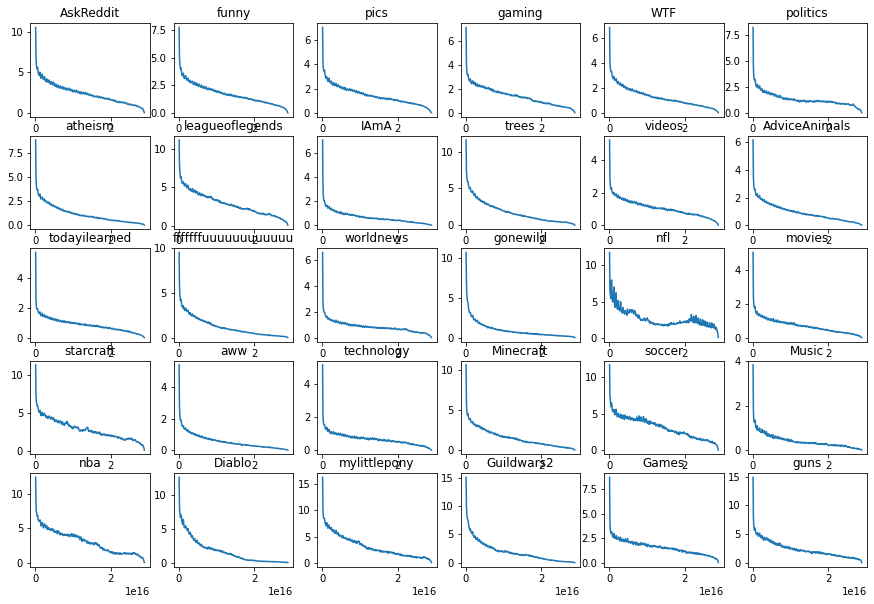

In [87]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(5, 6, figsize = (15, 10))
for i in range(5):
    for j in range(6):
        axs[i, j].plot(df_churn.iloc[(i*6+j),][1:])
        axs[i,j].set_title(index_list[i*6+j])

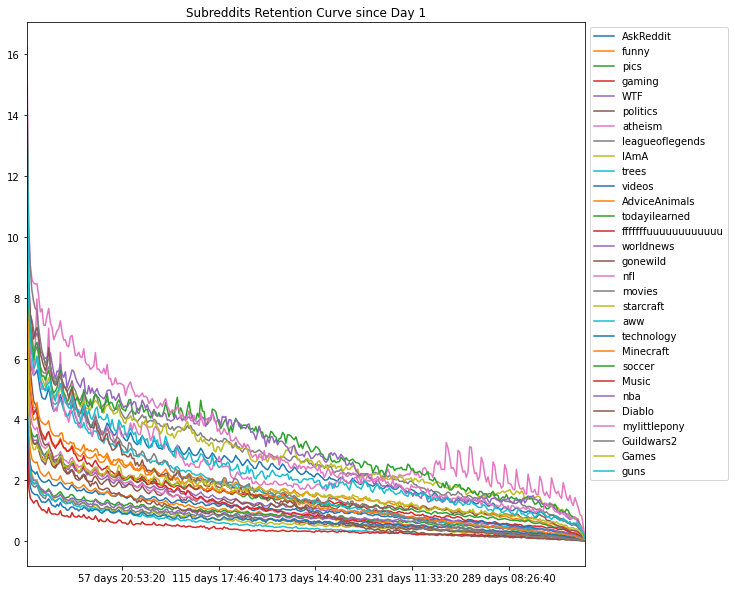

In [107]:
for index, row in df_churn.iterrows():
    row[1:].plot(label = index, figsize = (10,10))
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.title('Subreddits Retention Curve since Day 1')